### Imports

In [1]:
from matplotlib import pyplot as plt
from data import load_data, load_narx_data

x_train, y_train = load_data(section="train", split=[0.6, 0.2, 0.2], as_tensor=True)

plt.figure(figsize=(12,5)) 
plt.plot(x_train, y_train, '.') 
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.show() 
len(x_train)

y_train

x_val, y_val = load_data(section="validation", split=[0.6, 0.2, 0.2], as_tensor=True)

plt.figure(figsize=(12,5)) 
plt.plot(x_val, y_val, '.') 
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.show() 
len(x_val)

x_test, y_test = load_data(section="test", split=[0.6, 0.2, 0.2], as_tensor=True)

plt.figure(figsize=(12,5)) 
plt.plot(x_test, y_test, '.') 
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.show() 
len(x_test)

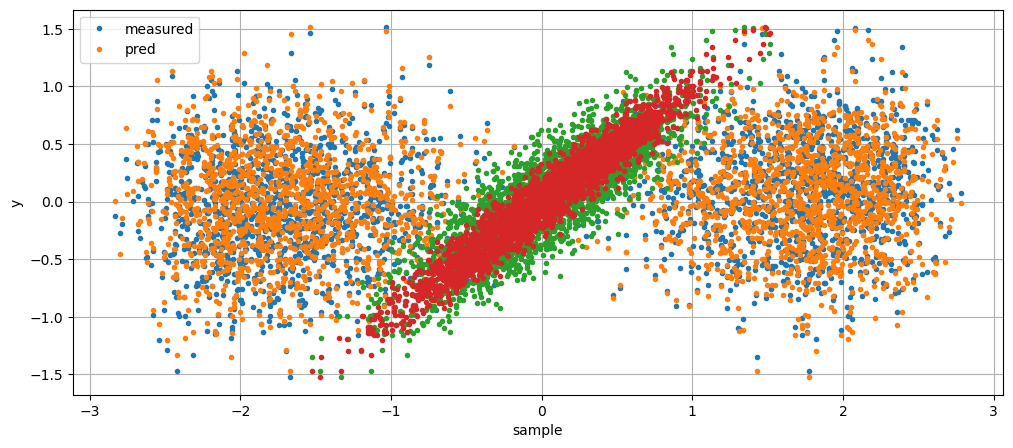

2721

In [2]:
x,y = load_narx_data(2, 2, section="train", split=[0.6, 0.2, 0.2], as_tensor=True)

plt.figure(figsize=(12,5)) 
plt.plot(x,y, '.') 
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.show() 
len(x)

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from data import load_narx_data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, Matern, Product

n_a, n_b = 2, 2

Xtrain,Ytrain = load_narx_data(n_a, n_b, section="train", split=[0.6, 0.2, 0.2], as_tensor=True)
Xval,Yval = load_narx_data(n_a, n_b, section="validation", split=[0.6, 0.2, 0.2], as_tensor=True)
Xtest,Ytest = load_narx_data(n_a, n_b, section="test", split=[0.6, 0.2, 0.2], as_tensor=True)


# Create individual kernels
# rbf_kernel = RBF(length_scale=1.0)
# matern_kernel = Matern(length_scale=1.0, nu=1.5)
# white_kernel = WhiteKernel(noise_level=0.1)

ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)


In [4]:
len(Xtrain)

2721

In [5]:
# Combine kernels using the Product kernel
# combined_kernel = Product(rbf_kernel, matern_kernel, white_kernel)
# combined_kernel = Product(rbf_kernel, matern_kernel)




# Create an instance of the Gaussian Process Regressor with the combined kernel
# reg = GaussianProcessRegressor(kernel=combined_kernel, n_restarts_optimizer=10)
reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10)

In [6]:
reg.fit(Xtrain, Ytrain)

GaussianProcessRegressor(kernel=RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=10)

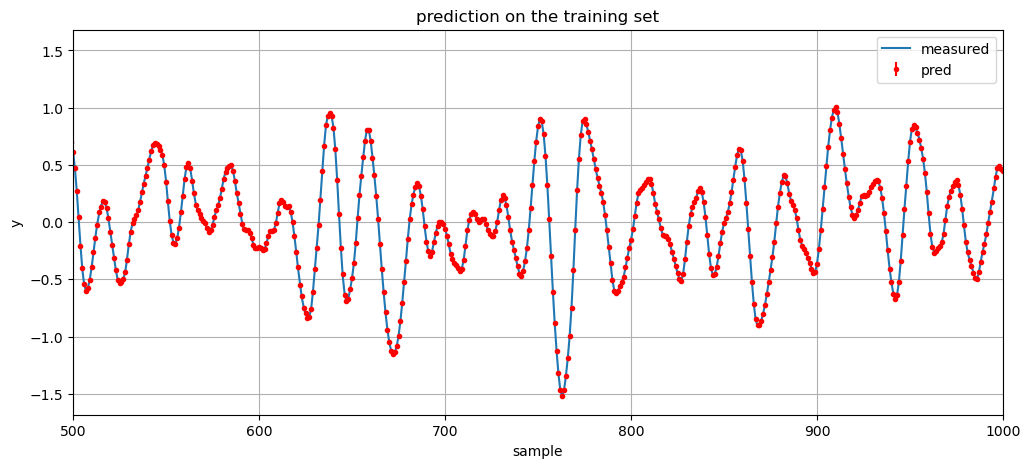

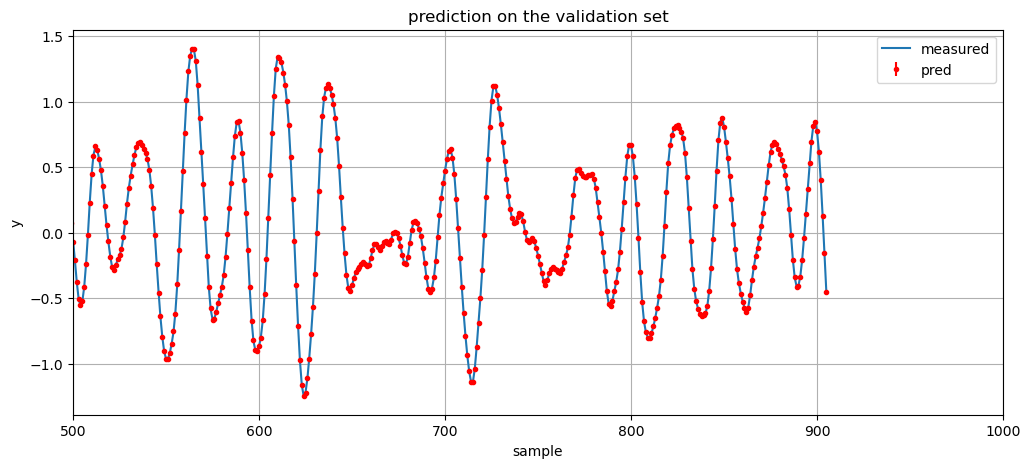

Validation NRMS= 0.008044607357530828


In [7]:
# Plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) 
plt.figure(figsize=(12,5)) 
plt.plot(Ytrain) 
plt.title('prediction on the training set')
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) 
plt.errorbar(np.arange(len(Xtrain)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r') 
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.xlim([500, 1000])
plt.show() 

plt.figure(figsize=(12,5)) 
plt.title('prediction on the validation set')
plt.plot(Yval) 
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True) 
plt.errorbar(np.arange(len(Xval)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r') 
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred']) 
plt.xlim([500, 1000])
plt.show() 

Yval = Yval.numpy()  # Convert Yval to a NumPy array

print(f'Validation NRMS= {np.mean((Yval_pred - Yval) ** 2, axis=0) ** 0.5 / np.std(Yval)}')


Resulting kernel hyperparameters: RBF(length_scale=4.09) + WhiteKernel(noise_level=2.28e-05)


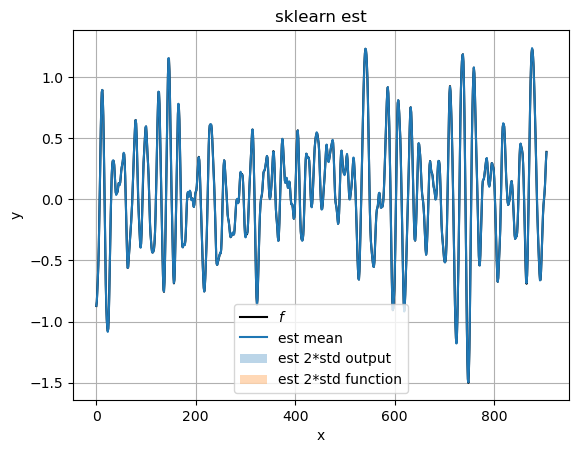

In [8]:
print('Resulting kernel hyperparameters:',reg.kernel_) #print optimized kernel
sigma_e = np.exp(reg.kernel_.k2.theta)**0.5 #extract the noise
#use regressor
ytest_p, ytest_std = reg.predict(Xtest,return_std=True) #a=)
ytest_std_mean = (ytest_std**2 - sigma_e**2)**0.5 #remove sigma_e noise to get mean deviation

#plot result
plt.plot(Ytest,'k',label='$f$')
plt.plot(ytest_p,label='est mean')
# plt.xlim(min(Xtest),max(Xtest))
# plt.xlim(500,1000)
plt.fill_between(ytest_p-2*ytest_std,ytest_p+2*ytest_std,alpha=0.3,label='est 2*std output')
plt.fill_between(ytest_p-2*ytest_std_mean,ytest_p+2*ytest_std_mean,alpha=0.3,label='est 2*std function')
plt.grid(); plt.legend(); plt.xlabel('x'); plt.ylabel('y'); plt.title('sklearn est')
plt.show()

Resulting kernel hyperparameters: RBF(length_scale=4.09) + WhiteKernel(noise_level=2.28e-05)


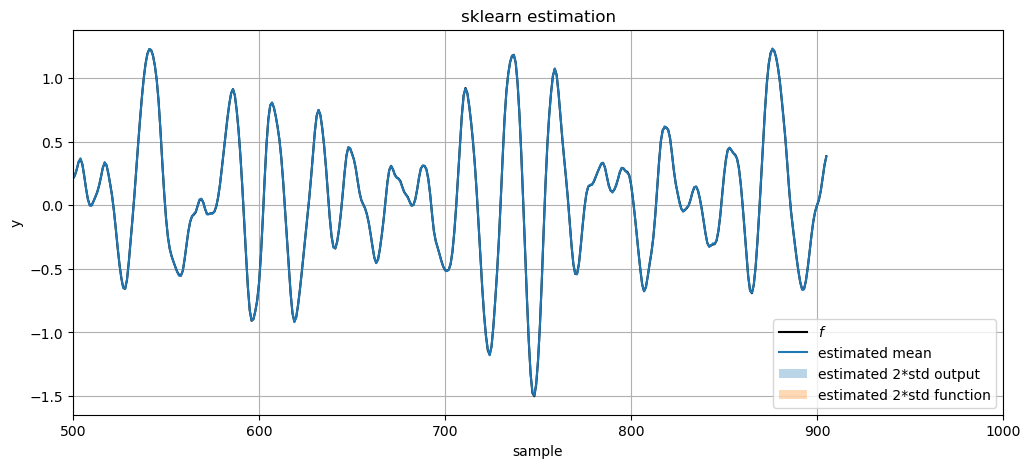

In [9]:
print('Resulting kernel hyperparameters:', reg.kernel_)  # print optimized kernel
sigma_e = np.exp(reg.kernel_.k2.theta) ** 0.5  # extract the noise

# Use regressor
ytest_p, ytest_std = reg.predict(Xtest, return_std=True)  # a)
ytest_std_mean = (ytest_std ** 2 - sigma_e ** 2) ** 0.5  # remove sigma_e noise to get mean deviation

# Plot result
plt.figure(figsize=(12, 5))
plt.plot(Ytest, 'k', label='$f$')
plt.plot(ytest_p, label='estimated mean')
plt.xlim([500, 1000])
plt.fill_between(np.arange(len(Xtest)), ytest_p - 2 * ytest_std, ytest_p + 2 * ytest_std, alpha=0.3, label='estimated 2*std output')
plt.fill_between(np.arange(len(Xtest)), ytest_p - 2 * ytest_std_mean, ytest_p + 2 * ytest_std_mean, alpha=0.3, label='estimated 2*std function')
plt.grid()
plt.legend()
plt.xlabel('sample')
plt.ylabel('y')
plt.title('sklearn estimation')
plt.show()
